In [1]:
#Importing dependencies

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torchvision.transforms import ToTensor
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

#checking versions
print(torch.__version__)
print(torchvision.__version__)

C:\Users\tarun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.2.0+cu118
0.17.0+cu118


In [2]:
#writing device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

###1. Getting data

        *** data with 3 classes of food, each class has ~75 training images and ~25 test set images

In [3]:
import requests
import zipfile
from pathlib import Path
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

### 1. Data preparation and data exploration

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path and returning it's contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 205 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 205 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 205 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 795 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 795 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 795 images in 'data\pizza_steak_sushi\train\sushi'.


In [5]:
#setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

### 2 Visualizing the data
        
        *** Let's write some code to:
        
            * get all the image paths
        
            * pick a random image path using Python's random.choice()

            *get the image class name using 

            *since, we are working with images, let's open the file with Python's PIL

Random Image Path : data\pizza_steak_sushi\train\sushi\249520.jpg
Image class : sushi
Image height : 384
Image width : 512


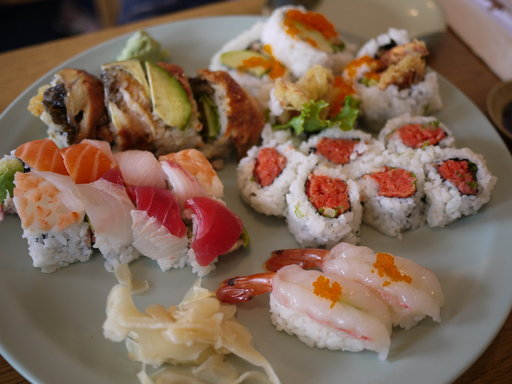

In [6]:
random.seed(42)

#get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#pick a random image path
random_image_path = random.choice(image_path_list)
random_image_path

#get the image class from the path name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
image_class

#open image
img = Image.open(random_image_path)

print(f"Random Image Path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

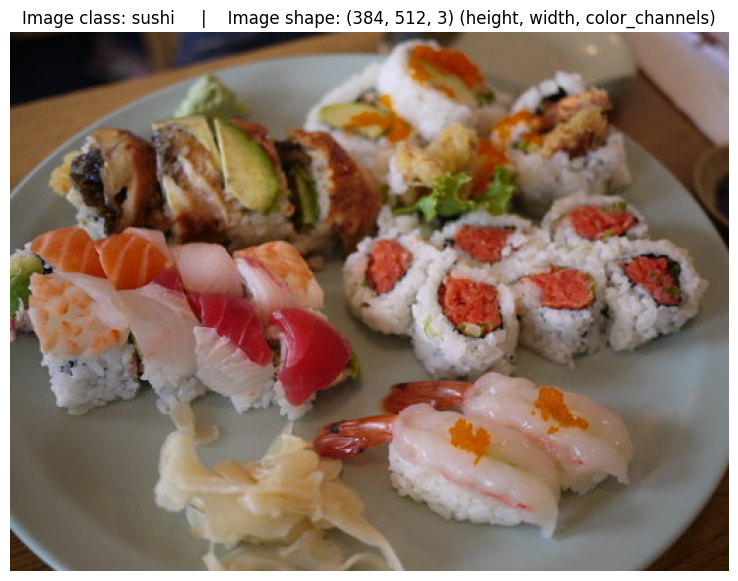

In [7]:
#turn the image into an array
img_as_arr = np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_arr)
plt.title(f"Image class: {image_class}     |    Image shape: {img_as_arr.shape} (height, width, color_channels)")
plt.axis(False)

### 3. Transforming data into tensors


In [8]:
#write a transform for image
data_transform = transforms.Compose([
    #resize our images to 64x64
    transforms.Resize(size=(64,64)),
    
    #flip the images
    transforms.RandomHorizontalFlip(p=0.5),
    
    #turn the image into a torch.Tensor
    transforms.ToTensor()
])

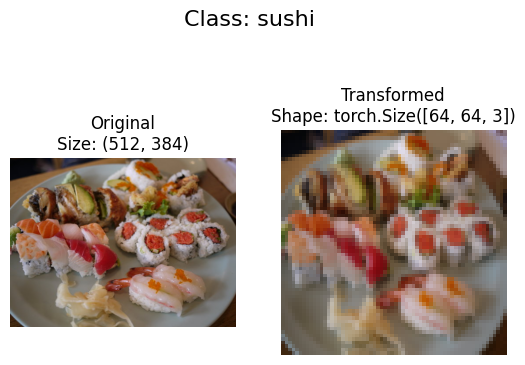

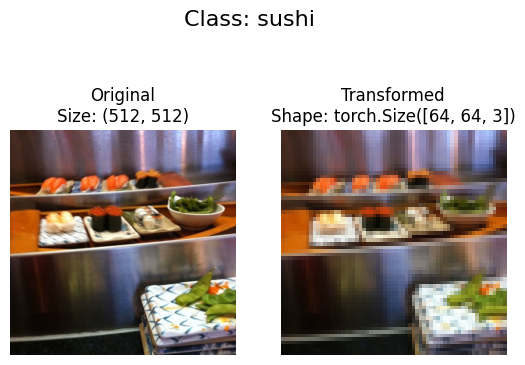

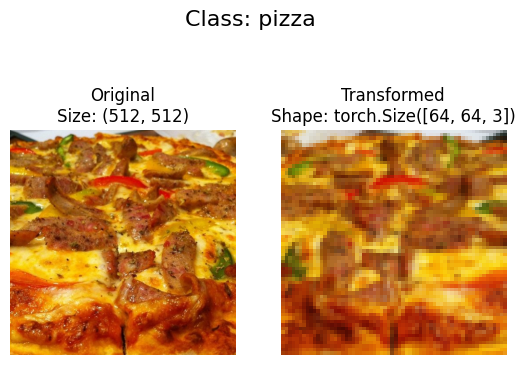

In [9]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            #Transform and plot target image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        seed=42)

### 4. loading image data using image folders

        ***using torchvision.datasets.ImageFolder

In [10]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 2385
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 615
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
class_names = train_data.classes
class_names
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5. Using Dataloader to convert the inputs into batches

In [12]:
train_dataloader = DataLoader(batch_size = 25,
                              dataset=train_data,
                              shuffle=True)

test_dataloader = DataLoader(batch_size = 25,
                              dataset=test_data,
                              shuffle=True)

In [13]:
torch.manual_seed(42)
img, label = next(iter(train_dataloader))

#batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape}        |       Label: {label}")


Image shape: torch.Size([25, 3, 64, 64])        |       Label: tensor([1, 1, 2, 0, 0, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2, 1, 2, 0, 0, 2,
        2])


### 6. Building a convolutional neural network to train a model

        *** we have used a resnet architecture to classify images

        *** refer to this website to find out how resnet9 architecture works (https://www.researchgate.net/figure/ResNet-9-architecture-A-convolutional-neural-net-with-9-layers-and-skip-connections_fig1_363585139)

In [14]:
class Resnet9(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(64),
			nn.ReLU())
		self.conv2 = nn.Sequential(
			nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(128),
			nn.ReLU(), 
			nn.MaxPool2d(2))
		self.conv3 = nn.Sequential(
			nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(128),
			nn.ReLU())
		self.conv4 = nn.Sequential(
			nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(128),
			nn.ReLU())
		self.conv5 = nn.Sequential(
			nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(256),
			nn.ReLU(), 
			nn.MaxPool2d(2))
		self.conv6 = nn.Sequential(
			nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(512),
			nn.ReLU(), 
			nn.MaxPool2d(2))
		self.conv7 = nn.Sequential(
			nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(512),
			nn.ReLU())
		self.conv8 = nn.Sequential(
			nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
			nn.BatchNorm2d(512),
			nn.ReLU())
		self.classifier = nn.Sequential(
			nn.MaxPool2d(4), 
			nn.Flatten(), 
			nn.Dropout(0.2),
			nn.Linear(2048, 10))

	def forward(self, x):
		out = self.conv1(x)
	
		out = self.conv2(out)
		res = out
		out = self.conv3(out)
		out = self.conv4(out) + res
		out = self.conv5(out)
		out = self.conv6(out)
		res = out
		out = self.conv7(out)
		out = self.conv8(out) + out
		out = self.classifier(out)

		return out  

In [15]:
#making an instance of resnet class
model_v0 = Resnet9().to(device)

#testing the model
model_v0(train_data[0][0].unsqueeze(dim=0).to(device))
# train_data[0][0].unsqueeze(dim=0).shape

tensor([[ 0.9106,  1.7445, -2.4225,  0.7925, -1.9609,  0.5074, -2.9549, -4.3519,
          1.3877,  0.1107]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7. Other forms of transforms (data augmentation)

        *** Data augmentation is the process of artificially adding diversity to your training data.

        *** This practice hopefully results in a model that's more generalizable to unseed data

        *** Refer to this article for further clearance on how to augment images for a better performing model https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [16]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=30),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
                      transforms.ToTensor()
])

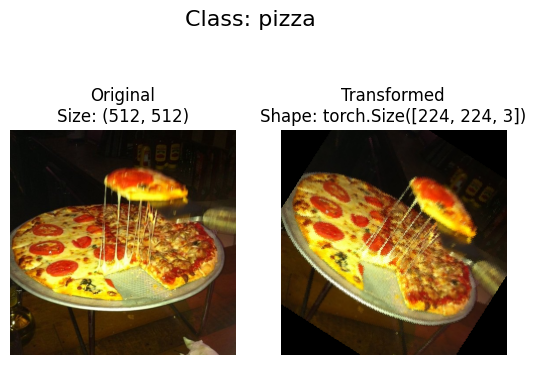

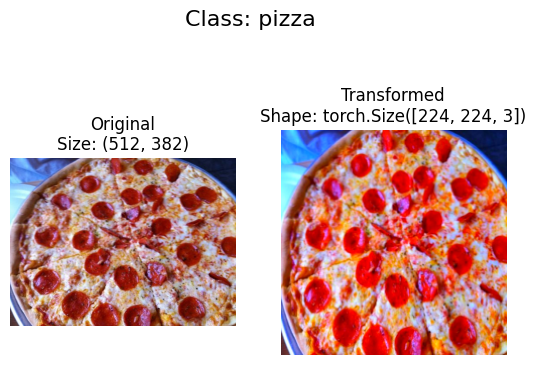

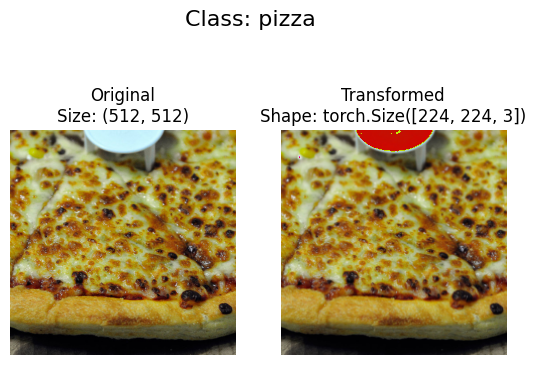

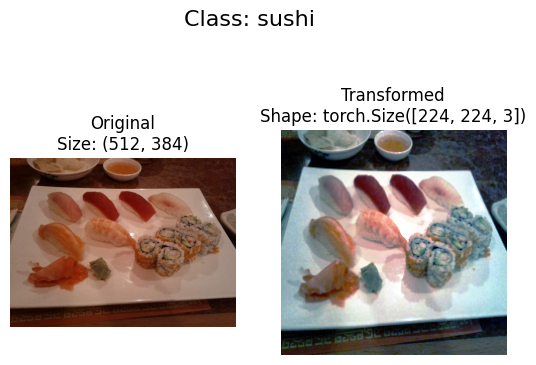

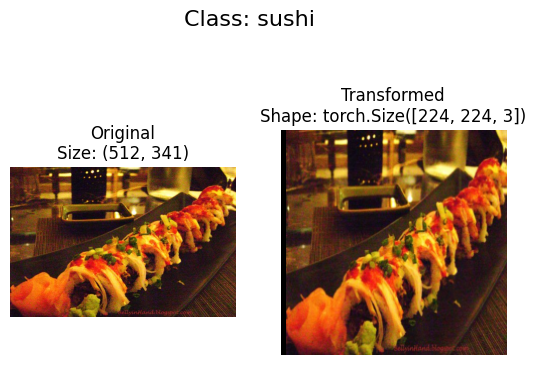

In [17]:
#Let's see how the augmented images came out...
torch.manual_seed(30)
plot_transformed_images(image_path_list,
                        train_transforms,
                        n=5)

### 8. Building a function to train a model

In [18]:
def model_training(model,
                   optimizer,
                   loss_fn,
                   train_data):
        train_loss, acc = 0, 0
        for batches,(img,label) in enumerate(train_data):
            
            img,label = img.to(device), label.to(device)
            #model in train mode
            model.train()
            
            #prediction
            y_pred = model(img)
            
            #loss calculation
            loss = loss_fn(y_pred, label)
            train_loss+=loss.item()

            #optimizer zero grad
            optimizer.zero_grad()
                        
            #loss backward propagation
            loss.backward()
            
            #optimizer step
            optimizer.step()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
            acc += (y_pred_class==label).sum().item()/len(y_pred)
        
        acc /= len(train_dataloader)
        train_loss /= len(train_dataloader)    
        return train_loss,acc  
            


In [19]:
#creating a test step function
import torch.utils


def test_model(model: torch.nn.Module,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    model.eval()
    
    test_loss, test_acc = 0,0
    
    with torch.inference_mode():
        for batch,(img,label) in enumerate(test_dataloader):
            
            test_logits = model(img.to(device))
            
            loss = loss_fn(test_logits,label.to(device))
            test_loss += loss.item()
             
            test_pred_label = torch.argmax(test_logits, dim=1)
            test_acc += accuracy_score(y_true = label.to('cpu'), y_pred=test_pred_label.to('cpu'))
            
        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)
        return test_loss,test_acc

In [20]:
#Using torchinfo module to get info about our model
# try:
#     import torchinfo
# except:
#     !pip install torchinfo
#     import torchinfo
    
from torchinfo import summary
summary(model_v0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
Resnet9                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           128
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
├─Sequential: 1-2                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-4                       [1, 128, 64, 64]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 64, 64]          256
│    └─ReLU: 2-6                         [1, 128, 64, 64]          --
│    └─MaxPool2d: 2-7                    [1, 128, 32, 32]          --
├─Sequential: 1-3                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 32, 32]          147,584
│    └─BatchNorm2d: 2-9                  [1, 128, 32, 32]          256


In [21]:
def train_test(model: torch.nn.Module,
               train_dataloader,
               test_dataloader,
               optimizer,
               loss_fn,
               epochs: int = 5):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = model_training(model=model,
                                               train_data=train_dataloader,
                                               loss_fn=loss_fn,
                                               optimizer=optimizer)
        
        test_loss, test_acc = test_model(model=model,
                                         test_dataloader=test_dataloader,
                                         loss_fn=loss_fn)
        
        print(f"Train Loss: {train_loss:.4f}    |   Train Accuracy: {train_acc:.4f}    |   Test Loss: {test_loss:.4f}   |   Test Accuracy:  {test_acc:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [22]:
#train and evaluate a model
torch.manual_seed(42)

#set number of epochs
epochs = 10

#loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v0.parameters(),
                             lr=0.001)

model_v0_results = train_test(model=model_v0,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=epochs)
# model_v0_results

 10%|█         | 1/10 [00:28<04:16, 28.53s/it]

Train Loss: 1.2346    |   Train Accuracy: 0.5260    |   Test Loss: 1.5213   |   Test Accuracy:  0.5456


 20%|██        | 2/10 [00:52<03:25, 25.69s/it]

Train Loss: 1.0713    |   Train Accuracy: 0.6081    |   Test Loss: 0.7935   |   Test Accuracy:  0.7003


 30%|███       | 3/10 [01:15<02:50, 24.41s/it]

Train Loss: 0.9078    |   Train Accuracy: 0.6571    |   Test Loss: 1.1141   |   Test Accuracy:  0.6043


 40%|████      | 4/10 [01:38<02:22, 23.82s/it]

Train Loss: 0.8700    |   Train Accuracy: 0.6823    |   Test Loss: 0.7411   |   Test Accuracy:  0.7376


 50%|█████     | 5/10 [02:01<01:58, 23.66s/it]

Train Loss: 0.7969    |   Train Accuracy: 0.7079    |   Test Loss: 1.0170   |   Test Accuracy:  0.6960


 60%|██████    | 6/10 [02:24<01:33, 23.40s/it]

Train Loss: 0.7782    |   Train Accuracy: 0.7165    |   Test Loss: 1.4722   |   Test Accuracy:  0.6347


 70%|███████   | 7/10 [02:47<01:09, 23.22s/it]

Train Loss: 0.6876    |   Train Accuracy: 0.7538    |   Test Loss: 0.7766   |   Test Accuracy:  0.7264


 80%|████████  | 8/10 [03:10<00:46, 23.13s/it]

Train Loss: 0.6972    |   Train Accuracy: 0.7515    |   Test Loss: 0.6508   |   Test Accuracy:  0.7381


 90%|█████████ | 9/10 [03:33<00:23, 23.15s/it]

Train Loss: 0.5957    |   Train Accuracy: 0.7758    |   Test Loss: 0.5439   |   Test Accuracy:  0.7883


100%|██████████| 10/10 [03:57<00:00, 23.76s/it]

Train Loss: 0.5777    |   Train Accuracy: 0.8048    |   Test Loss: 0.5537   |   Test Accuracy:  0.7941


### 9. Plot the loss curves of model_v0

        *** It's a way of tracking your model's progress over time

In [23]:
def plot_loss_curves(results: dict[str,list[float]]):
    """Plots training curves of a results dictionaries"""
    #loss values
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    #accuracy values
    acc = results["train_acc"]
    test_acc = results["test_acc"]
    
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize=(15,7))
    
    #plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    
    #plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

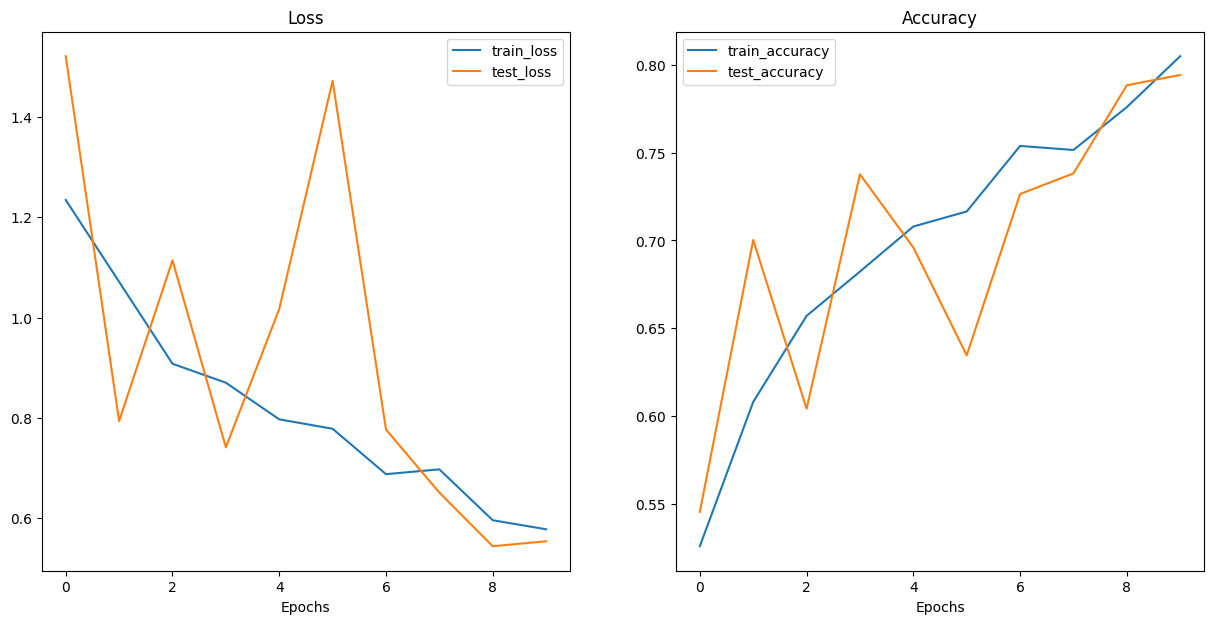

In [24]:
plot_loss_curves(model_v0_results)

### Reducing overfitting

        *** the loss curve indicates that our model is overfitted and hence it's performing worse on test set
     
        *** refer to this page to learn how to interpret the loss curve - (https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)
     
        *** things we could do to reduce overfitting:

                1.Get more data
                2.Data augmentation
                3.Better data
                4.Transfer Learning
                5.Simplifying our model
                6.Learning rate decay   (learning rate scheduling)
                7.Early stopping

        *** read some documentations and articles about how to balance underfitting and overfitting for more clarity



### 9. Making another cnn model with Data Augmentation

In [25]:
train_transform_trivial = transforms.Compose([transforms.Resize(size=(64,64)),
                                            transforms.TrivialAugmentWide(num_magnitude_bins=32),
                                            transforms.ToTensor()])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
                      transforms.ToTensor()])

In [26]:
train_aug = datasets.ImageFolder(root=train_dir,
                                 transform=train_transform_trivial,
                                 target_transform=None)

test_aug = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform_simple,
                                 target_transform=None)

#creating batches for these data

train_aug_dataloader = DataLoader(dataset=train_aug,
                                  batch_size=32,
                                  shuffle=True)

test_aug_dataloader = DataLoader(dataset=test_aug,
                                  batch_size=32,
                                  shuffle=True)

In [38]:
torch.manual_seed(42)
model_v1 = Resnet9().to(device)

model_v1

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), str

In [39]:
#set random seeds
torch.manual_seed(42)

#set number of epochs
epochs = 10

#setup loss function
loss_fn = nn.CrossEntropyLoss()

#set optimizer
optimizer = torch.optim.Adam(params=model_v1.parameters(),
                             lr=0.001)

# train model_v1

model_v1_results = train_test(model=model_v1,
                              train_dataloader=train_aug_dataloader,
                              test_dataloader=test_aug_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=epochs)

 10%|█         | 1/10 [00:23<03:30, 23.40s/it]

Train Loss: 1.0340    |   Train Accuracy: 0.3656    |   Test Loss: 1.0756   |   Test Accuracy:  0.5136


 20%|██        | 2/10 [00:46<03:03, 22.99s/it]

Train Loss: 0.8638    |   Train Accuracy: 0.4124    |   Test Loss: 0.9373   |   Test Accuracy:  0.6069


 30%|███       | 3/10 [01:19<03:13, 27.63s/it]

Train Loss: 0.7716    |   Train Accuracy: 0.4303    |   Test Loss: 0.8214   |   Test Accuracy:  0.6473


 40%|████      | 4/10 [01:44<02:40, 26.83s/it]

Train Loss: 0.7212    |   Train Accuracy: 0.4824    |   Test Loss: 0.7597   |   Test Accuracy:  0.6799


 50%|█████     | 5/10 [02:08<02:08, 25.68s/it]

Train Loss: 0.7477    |   Train Accuracy: 0.4607    |   Test Loss: 1.0247   |   Test Accuracy:  0.6388


 60%|██████    | 6/10 [02:32<01:40, 25.12s/it]

Train Loss: 0.7852    |   Train Accuracy: 0.4668    |   Test Loss: 1.0264   |   Test Accuracy:  0.6096


 70%|███████   | 7/10 [02:55<01:13, 24.55s/it]

Train Loss: 0.7006    |   Train Accuracy: 0.4814    |   Test Loss: 0.7884   |   Test Accuracy:  0.6551


 80%|████████  | 8/10 [03:19<00:48, 24.09s/it]

Train Loss: 0.6725    |   Train Accuracy: 0.4999    |   Test Loss: 0.6755   |   Test Accuracy:  0.7279


 90%|█████████ | 9/10 [03:42<00:23, 23.89s/it]

Train Loss: 0.6127    |   Train Accuracy: 0.5250    |   Test Loss: 0.8076   |   Test Accuracy:  0.7069


100%|██████████| 10/10 [04:05<00:00, 24.55s/it]

Train Loss: 0.6282    |   Train Accuracy: 0.5222    |   Test Loss: 0.6167   |   Test Accuracy:  0.7654


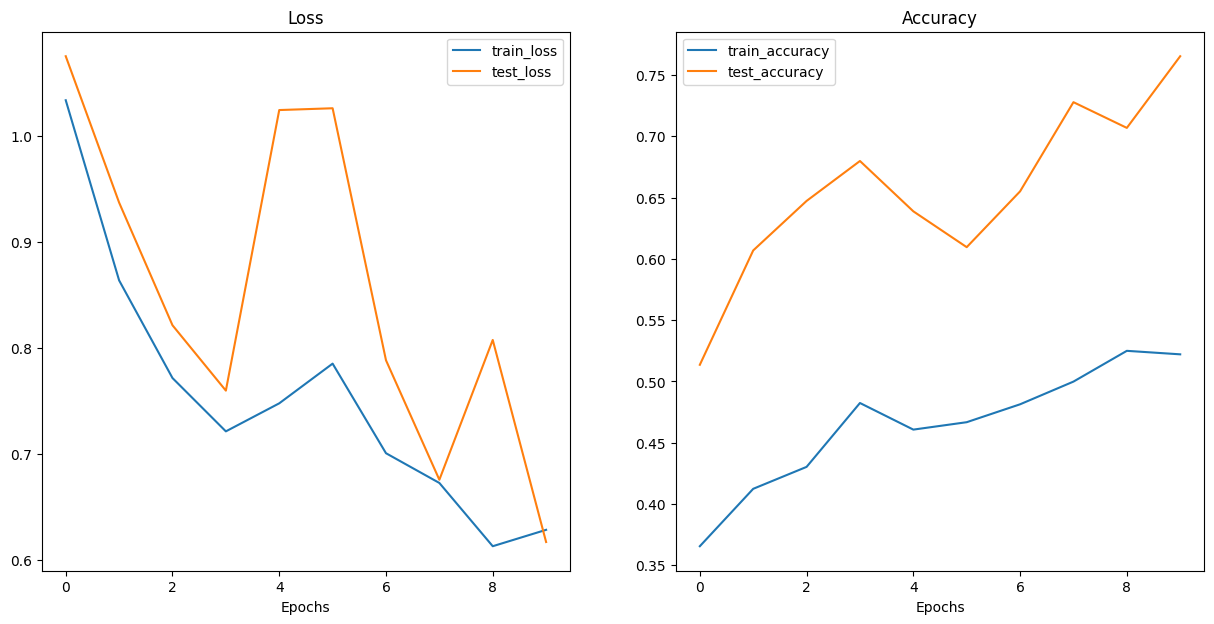

In [40]:
plot_loss_curves(model_v1_results)